In [1]:
import os
import lmfit
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib import rc
from PyAstronomy import pyasl
from mpdaf.obj import Cube, WCS, WaveCoord, iter_spe, iter_ima

def getSigma_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04) / 2.355

def model_OII(wave_vac, z, sigma_kms, flux_OII, r_OII3729_3727, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OII3727_vac = 3727.092
    wave_OII3729_vac = 3729.875

    wave_OII3727_obs = wave_OII3727_vac * (1 + z)
    wave_OII3729_obs = wave_OII3729_vac * (1 + z)

    sigma_OII3727_A = np.sqrt((sigma_kms / c_kms * wave_OII3727_obs) ** 2 + (getSigma_MUSE(wave_OII3727_obs)) ** 2)
    sigma_OII3729_A = np.sqrt((sigma_kms / c_kms * wave_OII3729_obs) ** 2 + (getSigma_MUSE(wave_OII3729_obs)) ** 2)

    flux_OII3727 = flux_OII / (1 + r_OII3729_3727)
    flux_OII3729 = flux_OII / (1 + 1.0 / r_OII3729_3727)

    peak_OII3727 = flux_OII3727 / np.sqrt(2 * sigma_OII3727_A ** 2 * np.pi)
    peak_OII3729 = flux_OII3729 / np.sqrt(2 * sigma_OII3729_A ** 2 * np.pi)

    OII3727_gaussian = peak_OII3727 * np.exp(-(wave_vac - wave_OII3727_obs) ** 2 / 2 / sigma_OII3727_A ** 2)
    OII3729_gaussian = peak_OII3729 * np.exp(-(wave_vac - wave_OII3729_obs) ** 2 / 2 / sigma_OII3729_A ** 2)

    return OII3727_gaussian + OII3729_gaussian + a * wave_vac + b


def model_Hbeta(wave_vac, z, sigma_kms, flux_Hbeta, a, b):
    # Constants
    c_kms = 2.998e5
    wave_Hbeta_vac = 4862.721

    wave_Hbeta_obs = wave_Hbeta_vac * (1 + z)
    sigma_Hbeta_A = np.sqrt((sigma_kms / c_kms * wave_Hbeta_obs) ** 2 + (getSigma_MUSE(wave_Hbeta_obs)) ** 2)

    peak_Hbeta = flux_Hbeta / np.sqrt(2 * sigma_Hbeta_A ** 2 * np.pi)
    Hbeta_gaussian = peak_Hbeta * np.exp(-(wave_vac - wave_Hbeta_obs) ** 2 / 2 / sigma_Hbeta_A ** 2)

    return Hbeta_gaussian + a * wave_vac + b


def model_OIII4960(wave_vac, z, sigma_kms, flux_OIII4960, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII4960_vac = 4960.295

    wave_OIII4960_obs = wave_OIII4960_vac * (1 + z)
    sigma_OIII4960_A = np.sqrt((sigma_kms / c_kms * wave_OIII4960_obs) ** 2 + (getSigma_MUSE(wave_OIII4960_obs)) ** 2)

    peak_OIII4960 = flux_OIII4960 / np.sqrt(2 * sigma_OIII4960_A ** 2 * np.pi)
    OIII4960_gaussian = peak_OIII4960 * np.exp(-(wave_vac - wave_OIII4960_obs) ** 2 / 2 / sigma_OIII4960_A ** 2)

    return OIII4960_gaussian + a * wave_vac + b


def model_OIII5008(wave_vac, z, sigma_kms, flux_OIII5008, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII5008_vac = 5008.239

    wave_OIII5008_obs = wave_OIII5008_vac * (1 + z)
    sigma_OIII5008_A = np.sqrt((sigma_kms / c_kms * wave_OIII5008_obs) ** 2 + (getSigma_MUSE(wave_OIII5008_obs)) ** 2)

    peak_OIII5008 = flux_OIII5008 / np.sqrt(2 * sigma_OIII5008_A ** 2 * np.pi)
    OIII5008_gaussian = peak_OIII5008 * np.exp(-(wave_vac - wave_OIII5008_obs) ** 2 / 2 / sigma_OIII5008_A ** 2)

    return OIII5008_gaussian + a * wave_vac + b


def model_all(wave_vac, z, r_OII3729_3727, sigma_kms, flux_OII, flux_Hbeta, flux_OIII5008, a_OII, a_Hbeta, 
              a_OIII4960, a_OIII5008, b_OII, b_Hbeta, b_OIII4960, b_OIII5008):

    m_OII = model_OII(wave_vac[0], z, sigma_kms, flux_OII, r_OII3729_3727, a_OII, b_OII)
    m_Hbeta = model_Hbeta(wave_vac[1], z, sigma_kms, flux_Hbeta, a_Hbeta, b_Hbeta)
    m_OIII4960 = model_OIII4960(wave_vac[2], z, sigma_kms, flux_OIII5008 / 3, a_OIII4960, b_OIII4960)
    m_OIII5008 = model_OIII5008(wave_vac[3], z, sigma_kms, flux_OIII5008, a_OIII5008, b_OIII5008)
    return np.hstack((m_OII, m_Hbeta, m_OIII4960, m_OIII5008))

In [3]:
path_cube_OII = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'cube_narrow', 'CUBE_OII_line_offset.fits')
path_cube_Hbeta = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'cube_narrow', 'CUBE_Hbeta_line_offset.fits')
path_cube_OIII4960 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'cube_narrow', 'CUBE_OIII_4960_line_offset.fits')
path_cube_OIII5008 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'cube_narrow', 'CUBE_OIII_5008_line_offset.fits')
cube_OII = Cube(path_cube_OII)
cube_Hbeta = Cube(path_cube_Hbeta)
cube_OIII4960 = Cube(path_cube_OIII4960)
cube_OIII5008 = Cube(path_cube_OIII5008)
# cube_OII = cube_OII.subcube((80, 100), 10, unit_center=None, unit_size=None)
# cube_Hbeta = cube_Hbeta.subcube((80, 100), 10, unit_center=None, unit_size=None)
# cube_OIII4960 = cube_OIII4960.subcube((80, 100),10, unit_center=None, unit_size=None)
# cube_OIII5008 = cube_OIII5008.subcube((80, 100), 10, unit_center=None, unit_size=None)

In [6]:
wave_OII_vac = pyasl.airtovac2(cube_OII.wave.coord())
wave_Hbeta_vac = pyasl.airtovac2(cube_Hbeta.wave.coord())
wave_OIII4960_vac = pyasl.airtovac2(cube_OIII4960.wave.coord())
wave_OIII5008_vac = pyasl.airtovac2(cube_OIII5008.wave.coord())
wave_vac_all = np.array([wave_OII_vac, wave_Hbeta_vac, wave_OIII4960_vac, wave_OIII5008_vac])
wave_vac_stack = np.hstack((wave_OII_vac, wave_Hbeta_vac, wave_OIII4960_vac, wave_OIII5008_vac))

#
flux_OII, flux_Hbeta = cube_OII.data * 1e-3, cube_Hbeta.data * 1e-3
flux_OIII4960, flux_OIII5008 = cube_OIII4960.data * 1e-3, cube_OIII5008.data * 1e-3
flux_OII_err, flux_Hbeta_err = np.sqrt(cube_OII.var) * 1e-3, np.sqrt(cube_Hbeta.var) * 1e-3
flux_OIII4960_err = np.sqrt(cube_OIII4960.var) * 1e-3
flux_OIII5008_err = np.sqrt(cube_OIII5008.var) * 1e-3
flux_all = np.vstack((flux_OII, flux_Hbeta, flux_OIII4960, flux_OIII5008))
flux_err_all = np.vstack((flux_OII_err, flux_Hbeta_err, flux_OIII4960_err, flux_OIII5008_err))

line = 'OOHbeta'
path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'fit_OOHbeta', 'fitOOHbeta_info_aperture_1.0.fits')
path_fit_info_err = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'fit_OOHbeta', 'fitOOHbeta_info_err_aperture_1.0.fits')
fit_info = fits.getdata(path_fit_info, 0, ignore_missing_end=True)
fit_info_err = fits.getdata(path_fit_info_err, 0, ignore_missing_end=True)


[z_fit, r_fit, fit_success, sigma_fit, flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII5008, a_fit_OII, a_fit_Hbeta,
 a_fit_OIII4960, a_fit_OIII5008, b_fit_OII, b_fit_Hbeta, b_fit_OIII4960, b_fit_OIII5008] = fit_info
[dz_fit, dr_fit, dsigma_fit, dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII5008, da_fit_OII, da_fit_Hbeta,
 da_fit_OIII4960, da_fit_OIII5008, db_fit_OII, db_fit_Hbeta, db_fit_OIII4960, db_fit_OIII5008] = fit_info_err


print(sigma_fit[80, 110])
print(flux_fit_OIII5008[80, 110])
print((flux_fit_OIII5008 / np.sqrt(2 * np.pi * sigma_fit ** 2))[80, 110])

c_kms = 2.998e5
wave_OIII5008_obs = 8150
sigma_OIII5008_A = np.sqrt((sigma_fit[80, 110] / c_kms * wave_OIII5008_obs) ** 2 + (getSigma_MUSE(wave_OIII5008_obs)) ** 2)
print(sigma_OIII5008_A)
print(0.01 * np.sqrt(2 * np.pi * sigma_OIII5008_A ** 2))
# print(z_fit[0:20, 0:20])
# fit_success[0:20, 0:20]

/Users/lzq/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


73.51429591734865
0.13129250408406404
0.0007124890516233618
2.2528325373114213
0.056470137360335064


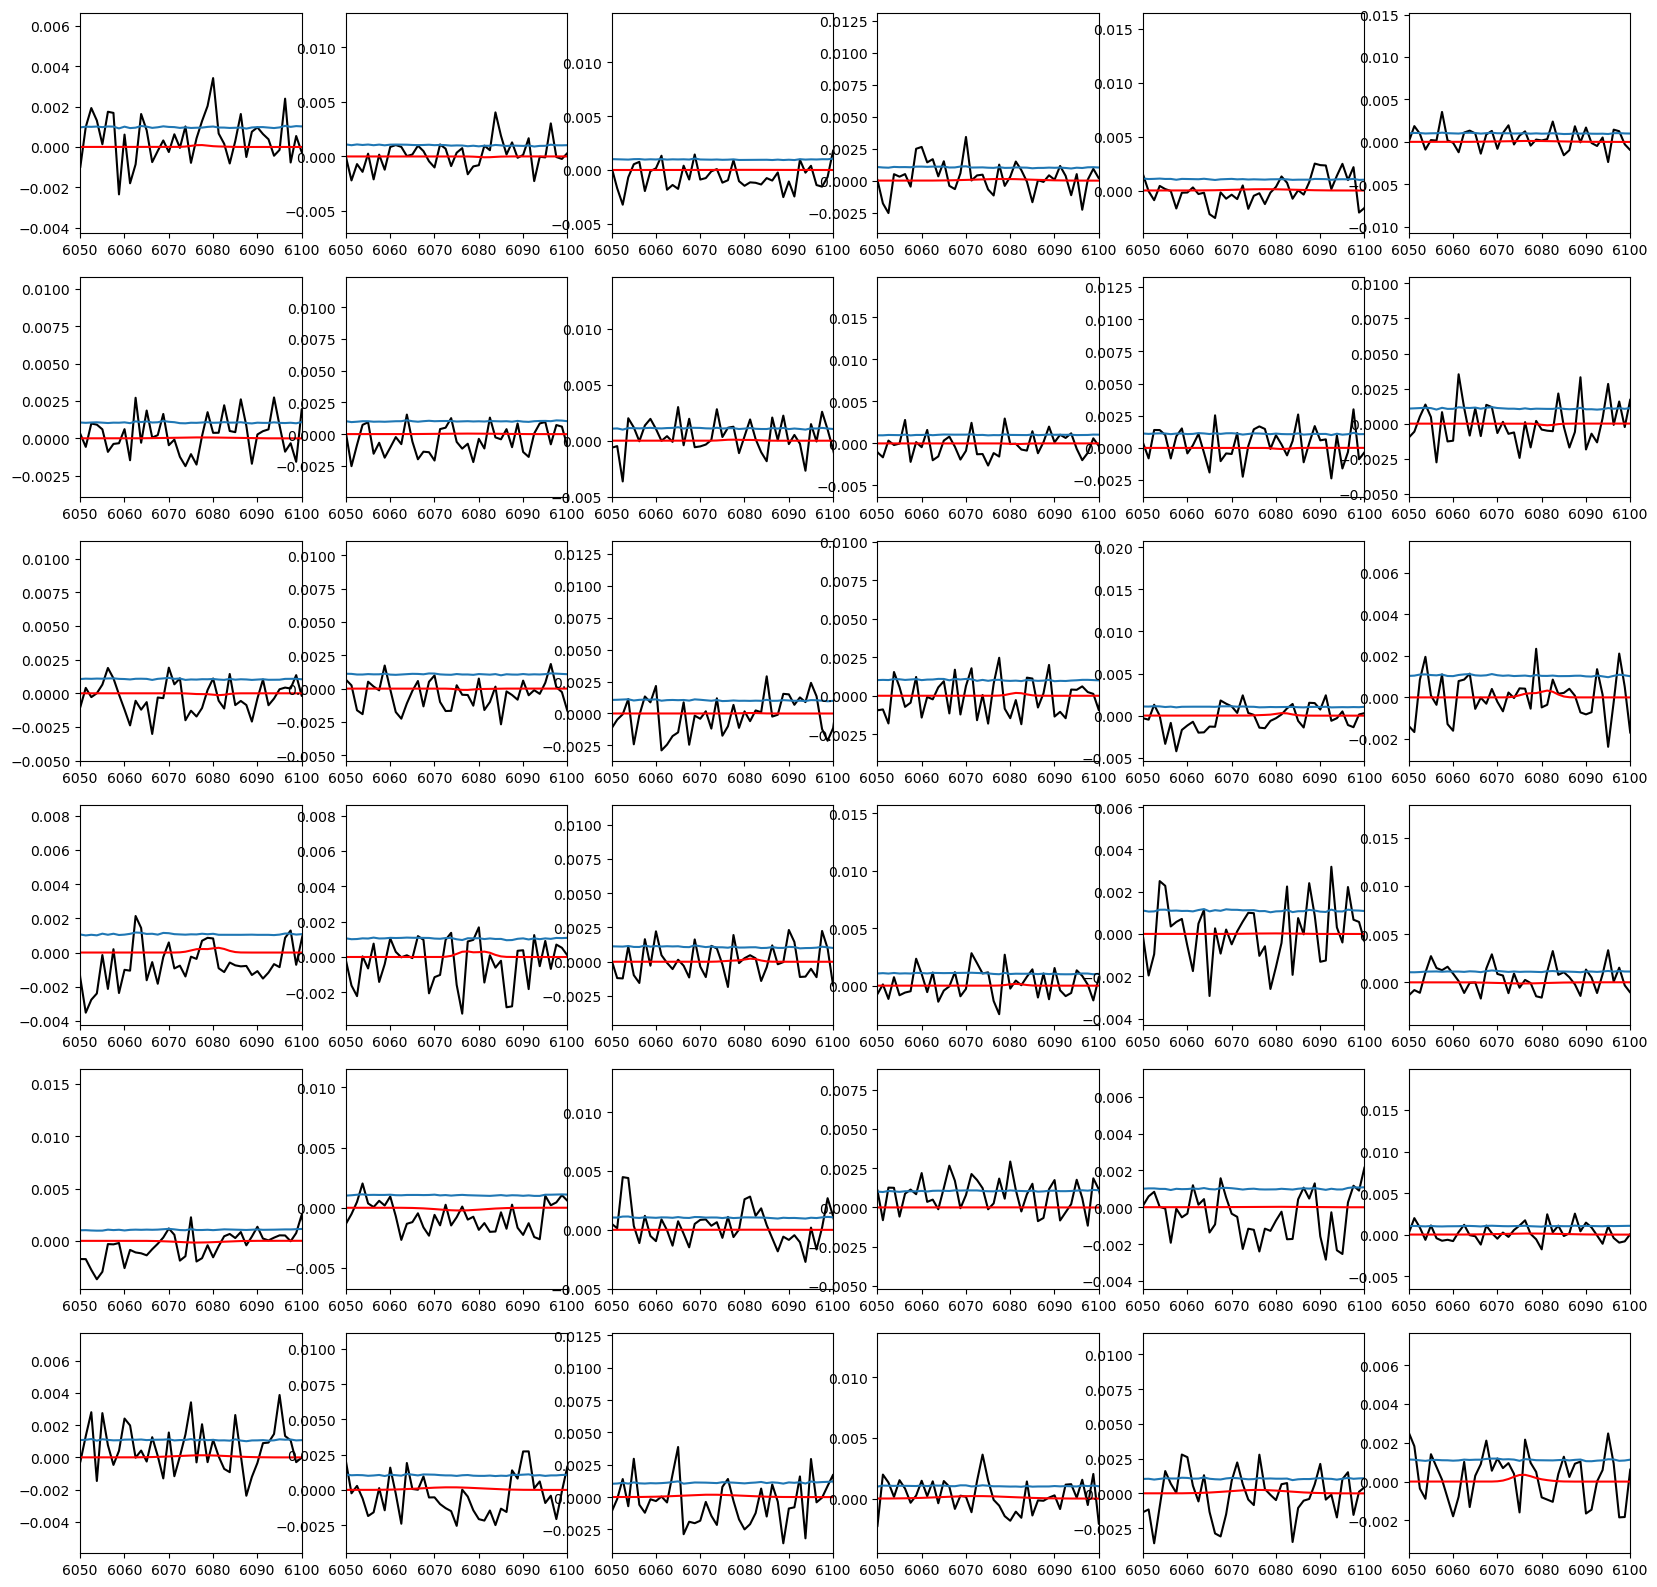

In [9]:
# print(sigma_fit_OII[50, 50], sigma_fit_Hbeta[50, 50], sigma_fit_OIII4960[50, 50], sigma_fit_Hbeta[50, 50])
fig, axarr = plt.subplots(6, 6, figsize=(20, 20))
axarr = axarr.ravel()
for i in range(36):
    num_y = 80 + i
    num_x = 30 + i
    axarr[i].plot(wave_vac_stack, flux_all[:, num_y, num_x], '-k')
    axarr[i].plot(wave_vac_stack, flux_err_all[:, num_y, num_x], '-C0')
    axarr[i].plot(wave_vac_stack, model_all(wave_vac_all, z_fit[num_y, num_x], 
                                            r_fit[num_y, num_x], *fit_info[3:][:, num_y, num_x]), '-r')
    # axarr[i].set_xlim(8100, 8200)
    axarr[i].set_xlim(6050, 6100)
    # axarr[i].set_ylim(flux_all[:, 100 + i, 100 + i].min(), flux_all[:, 100 + i, 100 + i].max())

In [ ]:
# path_cube_OIII = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_5008_line_offset.fits')
# cube_OIII = Cube(path_cube_OIII)
# # cube_OIII = cube_OIII.subcube((80, 100), 5, unit_center=None, unit_size=None)
# cube_OIII[0, :, :].write('/Users/lzq/Dropbox/Data/CGM/image_OIII_fitline.fits')



In [ ]:
# check OII

path_cube_OII = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OII_line_offset.fits')
cube_OII = Cube(path_cube_OII)
cube_OII = cube_OII.subcube((80, 100), 50, unit_center=None, unit_size=None)
wave_OII_vac = pyasl.airtovac2(cube_OII.wave.coord())
flux_OII = cube_OII.data * 1e-3
flux_OII_err = np.sqrt(cube_OII.var) * 1e-3

path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'fitOII_info_test1.fits')
fit_info = fits.getdata(path_fit_info, 0, ignore_missing_end=True)
[z_fit, sigma_fit, flux_fit, success_fit, r_fit, a_fit, b_fit] = fit_info

fig, axarr = plt.subplots(6, 6, figsize=(20, 20))
axarr = axarr.ravel()
for i in range(36):
    num_y = 80 + i
    num_x = 100 + i
    print(r_fit[num_y, num_x])
    axarr[i].plot(wave_OII_vac, flux_OII[:, num_y, num_x], '-k')
    axarr[i].plot(wave_OII_vac, flux_OII_err[:, num_y, num_x], '-C0')
    axarr[i].plot(wave_OII_vac, model_OII(wave_OII_vac, z_fit[num_y, num_x], sigma_fit[num_y, num_x],
                                          flux_fit[num_y, num_x], r_fit[num_y, num_x], 
                                          a_fit[num_y, num_x], b_fit[num_y, num_x]), '-r')
    #axarr[i].set_xlim(8100, 8200)
    # axarr[i].set_xlim(6050, 6100)
    # axarr[i].set_ylim(flux_all[:, 100 + i, 100 + i].min(), flux_all[:, 100 + i, 100 + i].max())